In [1]:
!git clone https://github.com/pandaZGV2/sampleData.git

Cloning into 'sampleData'...
remote: Enumerating objects: 11477, done.
remote: Total 11477 (delta 0), reused 0 (delta 0), pack-reused 11477
Receiving objects: 100% (11477/11477), 171.41 MiB | 35.79 MiB/s, done.
Updating files: 100% (11641/11641), done.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
import tensorflow_hub as hub
from PIL import Image
from io import BytesIO
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
import copy
import time
import cv2 as cv
from tqdm import tqdm_notebook as tqdm
import matplotlib.image as mpimg
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
import torchvision.utils as vutils
import matplotlib.animation as animation
from IPython.display import HTML
import torchvision.transforms.functional as TF
from PIL import Image
import cv2
import matplotlib.pyplot as plt

from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

In [3]:
tf.compat.v1.disable_eager_execution()

USE_GPU = True

if USE_GPU:
    device = '/device:GPU:0'
else:
    device = 'cpu'

# Constant to control how often we print when training models
print_every = 100

print('Using device: ', device)

Using device:  /device:GPU:0


In [4]:
img_dir = 'sampleData/archive/CelebDataProcessed'
img_list = os.listdir(img_dir)
print(len(img_list))
valid_ratio = 0.8

11641


In [5]:
class CelebFacesData(Dataset):
    def __init__(self,is_train=True):
        self.is_train = is_train
        self.transform = transforms.Compose([transforms.ToTensor(),])
        self.train_index = int(valid_ratio * len(img_list))
        self.crop = transforms.CenterCrop((256,256))
    def __len__(self):
        if self.is_train:
            return self.train_index
        else:
            return len(img_list) - self.train_index -1
    def __getitem__(self, index):
        if not self.is_train:
            index = self.train_index + index
        img = mpimg.imread(img_dir+'/'+img_list[index])
        img = self.crop(TF.to_pil_image(img))
        img = self.transform(img)
        img = (img-0.5) /0.5
        return img

In [6]:
batch_size=500
dataset = CelebFacesData()
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [7]:
a = next(iter(dataloader))

In [8]:
test_set = []
for i in range(500):
    img = a[i]
    img = img * 0.5 + 0.5
    img = img.permute(1,2,0)
    nimg = cv2.resize(np.array(img), (128,128))
    test_set.append(nimg)

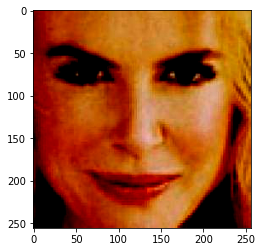

In [9]:
plt.imshow(test_set[2])
img = a[2]
# print(um)
img = img.permute(1,2,0)
plt.imshow(img)

2022-12-02 11:26:39.027277: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:26:39.028233: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:26:39.029256: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:26:39.030016: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:26:39.030744: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

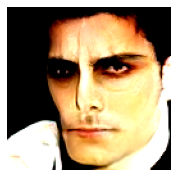

In [10]:
import cv2

generator = hub.Module("https://tfhub.dev/google/progan-128/1")

with tf.device(device):
    latent = tf.placeholder(tf.float32, shape=(1, 512))
    z = latent
    np.random.seed(4208)
    latent_np = np.random.uniform(low=-1.0, high=1.0, size=(1, 512))

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    z_np = sess.run(z, feed_dict={latent: np.reshape(latent_np, (1,512))})
    img = generator(z_np).eval()
    img = (img * 255).astype(np.uint8)
    
img = img.reshape((128, 128, 3))
plt.axis('off')
fig = plt.gcf()
fig.set_size_inches( 3, 3 )
plt.imshow(img)
plt.savefig('original.png', bbox_inches='tight', pad_inches=0, dpi=170)
# img = cv2.imread('original.png')
# print(img.shape)

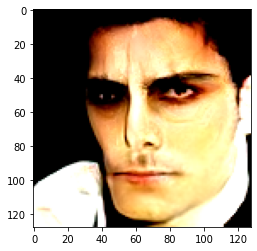

In [11]:
tf.reset_default_graph()

img = (img / 255).astype(np.float32)

# print(img)

truth = tf.Variable(img, tf.float32)
truth = tf.expand_dims(truth, 0)
truth = tf.cast(truth, tf.float32) 

plt.imshow((img * 255).astype(np.uint8))

np.random.seed(42)
zp1 = np.random.uniform(low=-1.0, high=1.0, size=(1, 512))
zp = tf.Variable(zp1, dtype=tf.float32)

In [12]:
def compute_results_table(orig, recon, jpeg1, jpeg10, kmeans_4, array_tba, array_gan, array_jpeg1, array_jpeg10, array_kmeans):
    original = cv2.imread(orig)
    original = cv2.resize(original, (128, 128))
    original = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
    
    reconstructed = cv2.imread(recon)
    reconstructed = cv2.resize(reconstructed, (128, 128))
    reconstructed = cv2.cvtColor(reconstructed, cv2.COLOR_BGR2GRAY)
    
    jpeg_1 = cv2.imread(jpeg1)
    jpeg_1 = cv2.resize(jpeg_1, (128, 128))
    jpeg_1 = cv2.cvtColor(jpeg_1, cv2.COLOR_BGR2GRAY)
    
    jpeg_10 = cv2.imread(jpeg10)
    jpeg_10 = cv2.resize(jpeg_10, (128, 128))
    jpeg_10 = cv2.cvtColor(jpeg_10, cv2.COLOR_BGR2GRAY)

    kmeans4 = cv2.imread(kmeans_4)
    kmeans4 = cv2.resize(kmeans4, (128, 128))
    kmeans4 = cv2.cvtColor(kmeans4, cv2.COLOR_BGR2GRAY)
    
    def mse(a, b):
        err = np.sum((a.astype("float") - b.astype("float")) ** 2)
        err = err / float(a.shape[0] * a.shape[1])
        return err

    def cr(a,b):
        cr = (a.shape[0] * a.shape[1]) / os.stat(b).st_size
        return cr
    
    def bpp(a,b):
        bpp = 13.63/cr(a,b)
        return bpp
        
    mse_err_original = mse(original, original)
    ssim_err_original = ssim(original, original)
    psnr_err_original = psnr(original, original)
    bpp_err_original = bpp(original, orig)
    cr_err_original = cr(original, orig)
    
    mse_err_jpeg1 = mse(original, jpeg_1)
    ssim_err_jpeg1 = ssim(original, jpeg_1)
    psnr_err_jpeg1 = psnr(original, jpeg_1)
    bpp_err_jpeg1 = bpp(original, jpeg1)
    cr_err_jpeg1 = cr(original, jpeg1)
    
    mse_err_jpeg10 = mse(original, jpeg_10)
    ssim_err_jpeg10 = ssim(original, jpeg_10)
    psnr_err_jpeg10 = psnr(original, jpeg_10)
    bpp_err_jpeg10 = bpp(original, jpeg10)
    cr_err_jpeg10 = cr(original, jpeg10)
    
    mse_err_gan = mse(original, reconstructed)
    ssim_err_gan = ssim(original, reconstructed)
    psnr_err_gan = psnr(original, reconstructed)
    bpp_err_gan = bpp(original, recon)
    cr_err_gan = cr(original, recon)

    mse_err_km = mse(original, kmeans4)
    ssim_err_km = ssim(original, kmeans4)
    psnr_err_km = psnr(original, kmeans4)
    bpp_err_km = bpp(original, kmeans_4)
    cr_err_km = cr(original, kmeans_4)
    
    temp_arr = [mse_err_gan, ssim_err_gan, psnr_err_gan, bpp_err_gan, cr_err_gan]
    temp_arr1 = [mse_err_jpeg1, ssim_err_jpeg1, psnr_err_jpeg1, bpp_err_jpeg1, cr_err_jpeg1]
    temp_arr2 = [mse_err_jpeg10, ssim_err_jpeg10, psnr_err_jpeg10, bpp_err_jpeg10, cr_err_jpeg10]
    temp_arr3 = [mse_err_km, ssim_err_km, psnr_err_km, bpp_err_km, cr_err_km]
    temp_arr4 = [mse_err_original, ssim_err_original, psnr_err_original, bpp_err_original, cr_err_original]
    
    array_gan.append(temp_arr)
    array_jpeg1.append(temp_arr1)
    array_jpeg10.append(temp_arr2)
    array_kmeans.append(temp_arr3)
    array_tba.append(temp_arr4)

In [13]:
error_orig = []
error_gan = []
error_jpeg1 = []
error_jpeg10 = []
error_km = []
# compute_results_table("original.png", "reconstructed.png", "photo-quality1.jpeg", "photo-quality10.jpeg", global_array)

2022-12-02 11:26:55.515576: W tensorflow/core/common_runtime/graph_constructor.cc:1511] Importing a graph with a lower producer version 26 into an existing graph with producer version 808. Shape inference will have run different parts of the graph with different producer versions.


(128, 128, 3)


2022-12-02 11:26:57.096535: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:26:57.097782: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:26:57.098982: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:26:57.099678: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:26:57.100715: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 50103.173567, z_loss = 0.850612
1000) eta=0.100000, loss = 20055.626911, z_loss = 1.020976


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


<Figure size 216x216 with 0 Axes>

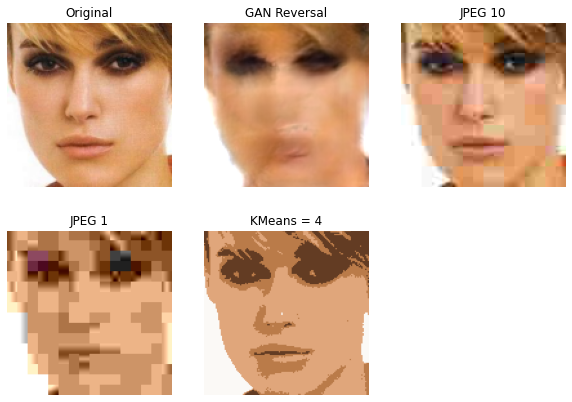

(128, 128, 3)


2022-12-02 11:27:42.037072: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:27:42.037945: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:27:42.039041: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:27:42.039739: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:27:42.040875: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 51620.046169, z_loss = 0.850612
1000) eta=0.100000, loss = 23738.357985, z_loss = 1.022720


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


(128, 128, 3)


2022-12-02 11:28:27.775551: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:28:27.776419: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:28:27.777434: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:28:27.778118: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:28:27.779199: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 51267.895581, z_loss = 0.850612
1000) eta=0.100000, loss = 15446.042807, z_loss = 1.017543


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


(128, 128, 3)


2022-12-02 11:29:14.977478: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:29:14.978671: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:29:14.979947: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:29:14.980660: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:29:14.981706: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 56488.397527, z_loss = 0.850612
1000) eta=0.100000, loss = 18329.864623, z_loss = 1.077373


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


(128, 128, 3)


2022-12-02 11:30:01.245930: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:30:01.247028: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:30:01.248200: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:30:01.248906: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:30:01.250005: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 48146.456708, z_loss = 0.850612
1000) eta=0.100000, loss = 18781.061076, z_loss = 1.009191


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


(128, 128, 3)


2022-12-02 11:30:47.825226: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:30:47.826170: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:30:47.827280: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:30:47.827995: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:30:47.829072: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 44186.788666, z_loss = 0.850612
1000) eta=0.100000, loss = 9575.717819, z_loss = 1.076560


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


<Figure size 216x216 with 0 Axes>

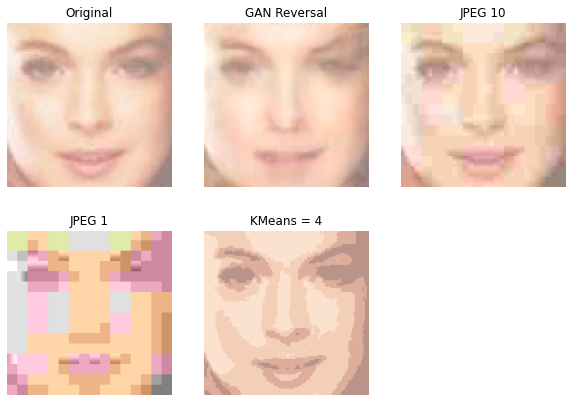

(128, 128, 3)


2022-12-02 11:31:35.508654: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:31:35.509857: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:31:35.511046: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:31:35.511692: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:31:35.512933: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 55594.174790, z_loss = 0.850612
1000) eta=0.100000, loss = 17743.364270, z_loss = 1.017045


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


(128, 128, 3)


2022-12-02 11:32:22.210853: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:32:22.211777: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:32:22.212852: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:32:22.213530: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:32:22.214619: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 50199.025780, z_loss = 0.850612
1000) eta=0.100000, loss = 16210.899357, z_loss = 1.028262


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


(128, 128, 3)


2022-12-02 11:33:08.759976: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:33:08.761098: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:33:08.762361: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:33:08.763074: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:33:08.764150: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 49741.271487, z_loss = 0.850612
1000) eta=0.100000, loss = 13023.378231, z_loss = 1.027121


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


(128, 128, 3)


2022-12-02 11:33:55.265393: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:33:55.266261: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:33:55.267318: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:33:55.267959: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:33:55.269043: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 52431.524621, z_loss = 0.850612
1000) eta=0.100000, loss = 21273.272865, z_loss = 1.012339


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


(128, 128, 3)


2022-12-02 11:34:42.352741: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:34:42.357509: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:34:42.358918: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:34:42.359582: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:34:42.360659: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 56002.570872, z_loss = 0.850612
1000) eta=0.100000, loss = 19879.196982, z_loss = 1.033259


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


<Figure size 216x216 with 0 Axes>

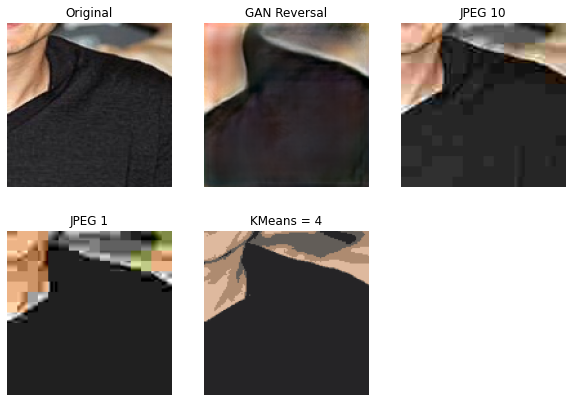

(128, 128, 3)


2022-12-02 11:35:29.379218: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:35:29.380339: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:35:29.381570: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:35:29.382310: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:35:29.383556: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 51452.375530, z_loss = 0.850612
1000) eta=0.100000, loss = 20410.552566, z_loss = 1.040385


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


(128, 128, 3)


2022-12-02 11:36:15.940254: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:36:15.941366: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:36:15.942575: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:36:15.943253: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:36:15.944300: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 54368.796632, z_loss = 0.850612
1000) eta=0.100000, loss = 19464.642267, z_loss = 1.018969


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


(128, 128, 3)


2022-12-02 11:37:03.230528: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:37:03.231603: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:37:03.232645: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:37:03.233329: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:37:03.234416: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 52363.124643, z_loss = 0.850612
1000) eta=0.100000, loss = 19713.258822, z_loss = 1.044969


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


(128, 128, 3)


2022-12-02 11:37:50.073274: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:37:50.074275: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:37:50.075320: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:37:50.075993: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:37:50.077125: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 52990.425459, z_loss = 0.850612
1000) eta=0.100000, loss = 21283.028233, z_loss = 1.047388


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


(128, 128, 3)


2022-12-02 11:38:36.869980: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:38:36.870951: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:38:36.872101: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:38:36.872724: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:38:36.873777: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 49990.391895, z_loss = 0.850612
1000) eta=0.100000, loss = 21501.436865, z_loss = 1.010166


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


<Figure size 216x216 with 0 Axes>

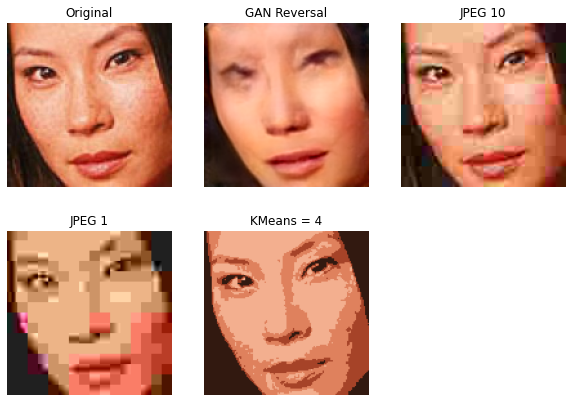

(128, 128, 3)


2022-12-02 11:39:23.947217: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:39:23.948118: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:39:23.949342: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:39:23.950163: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:39:23.951287: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 50626.184571, z_loss = 0.850612
1000) eta=0.100000, loss = 18390.261090, z_loss = 1.000145


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


(128, 128, 3)


2022-12-02 11:40:10.609033: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:40:10.609926: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:40:10.611054: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:40:10.611694: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:40:10.612761: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 49843.352097, z_loss = 0.850612
1000) eta=0.100000, loss = 20116.662884, z_loss = 1.015051


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


(128, 128, 3)


2022-12-02 11:40:57.172252: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:40:57.173114: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:40:57.174219: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:40:57.174847: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:40:57.175903: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 50271.045747, z_loss = 0.850612
1000) eta=0.100000, loss = 22849.782278, z_loss = 1.000564


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


(128, 128, 3)


2022-12-02 11:41:43.661443: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:41:43.662473: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:41:43.663592: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:41:43.664278: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:41:43.665404: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 49887.819059, z_loss = 0.850612
1000) eta=0.100000, loss = 15319.424558, z_loss = 1.003571


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


(128, 128, 3)


2022-12-02 11:42:30.354223: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:42:30.355134: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:42:30.356279: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:42:30.356945: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:42:30.357995: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 53359.575270, z_loss = 0.850612
1000) eta=0.100000, loss = 23139.342700, z_loss = 1.013897


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


<Figure size 216x216 with 0 Axes>

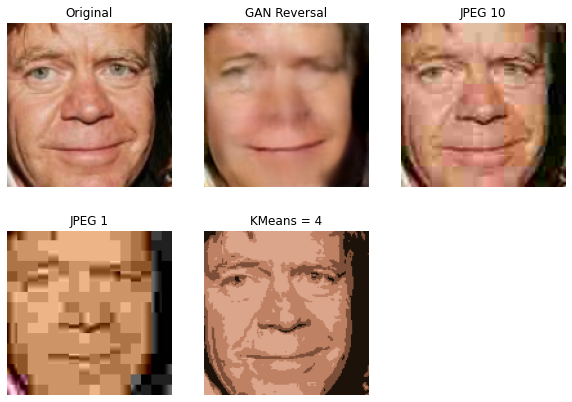

(128, 128, 3)


2022-12-02 11:43:17.062219: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:43:17.063189: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:43:17.064271: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:43:17.064916: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:43:17.065954: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 57833.774082, z_loss = 0.850612
1000) eta=0.100000, loss = 28825.645083, z_loss = 1.019637


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


(128, 128, 3)


2022-12-02 11:44:03.657296: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:44:03.658753: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:44:03.660137: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:44:03.661010: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:44:03.662411: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 49948.114756, z_loss = 0.850612
1000) eta=0.100000, loss = 18182.700799, z_loss = 1.034181


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


(128, 128, 3)


2022-12-02 11:44:50.499504: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:44:50.500419: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:44:50.501658: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:44:50.502345: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:44:50.503504: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 52425.563653, z_loss = 0.850612
1000) eta=0.100000, loss = 20482.770199, z_loss = 1.017124


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


(128, 128, 3)


2022-12-02 11:45:36.788372: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:45:36.789216: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:45:36.790392: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:45:36.791036: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:45:36.792125: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 53461.303183, z_loss = 0.850612
1000) eta=0.100000, loss = 14755.996795, z_loss = 1.035039


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


(128, 128, 3)


2022-12-02 11:46:23.190035: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:46:23.191227: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:46:23.192228: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:46:23.192907: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:46:23.193904: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 54580.647424, z_loss = 0.850612
1000) eta=0.100000, loss = 16836.320414, z_loss = 1.025757


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


<Figure size 216x216 with 0 Axes>

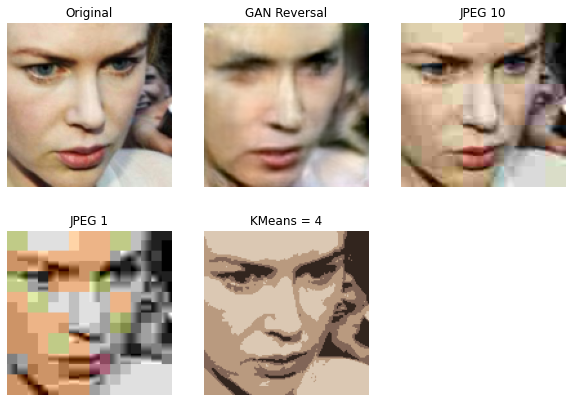

(128, 128, 3)


2022-12-02 11:47:10.100671: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:47:10.101726: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:47:10.102764: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:47:10.103404: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:47:10.104463: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 51266.407277, z_loss = 0.850612
1000) eta=0.100000, loss = 21436.947562, z_loss = 1.023990


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


(128, 128, 3)


2022-12-02 11:47:56.461380: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:47:56.462537: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:47:56.463673: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:47:56.464378: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:47:56.465474: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 50205.994454, z_loss = 0.850612
1000) eta=0.100000, loss = 21786.544003, z_loss = 1.034132


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


(128, 128, 3)


2022-12-02 11:48:42.754083: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:48:42.754931: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:48:42.756071: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:48:42.756702: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:48:42.757784: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 49534.610380, z_loss = 0.850612
1000) eta=0.100000, loss = 13798.001777, z_loss = 1.009062


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


(128, 128, 3)


2022-12-02 11:49:29.457956: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:49:29.458756: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:49:29.459866: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:49:29.460493: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:49:29.461518: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 51855.357130, z_loss = 0.850612
1000) eta=0.100000, loss = 23327.078314, z_loss = 1.008440


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


(128, 128, 3)


2022-12-02 11:50:16.069847: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:50:16.070688: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:50:16.071847: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:50:16.072494: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:50:16.073557: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 50183.762911, z_loss = 0.850612
1000) eta=0.100000, loss = 18711.219303, z_loss = 1.030399


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


<Figure size 216x216 with 0 Axes>

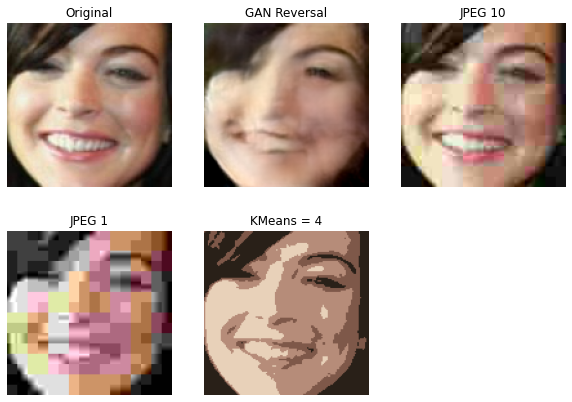

(128, 128, 3)


2022-12-02 11:51:03.121668: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:51:03.122660: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:51:03.123754: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:51:03.124433: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:51:03.125428: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 47198.294574, z_loss = 0.850612
1000) eta=0.100000, loss = 15622.759545, z_loss = 1.016296


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


(128, 128, 3)


2022-12-02 11:51:49.365797: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:51:49.367053: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:51:49.368162: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:51:49.368932: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:51:49.370091: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 48701.218200, z_loss = 0.850612
1000) eta=0.100000, loss = 11077.823652, z_loss = 1.031454


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


(128, 128, 3)


2022-12-02 11:52:36.709988: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:52:36.710963: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:52:36.711921: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:52:36.712527: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:52:36.713553: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 52451.070240, z_loss = 0.850612
1000) eta=0.100000, loss = 24945.802854, z_loss = 1.035499


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


(128, 128, 3)


2022-12-02 11:53:23.367215: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:53:23.368101: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:53:23.369169: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:53:23.369799: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:53:23.370848: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 50486.458392, z_loss = 0.850612
1000) eta=0.100000, loss = 17897.171201, z_loss = 1.011347


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


(128, 128, 3)


2022-12-02 11:54:10.058275: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:54:10.059629: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:54:10.061135: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:54:10.062161: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:54:10.063435: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 50412.415262, z_loss = 0.850612
1000) eta=0.100000, loss = 14544.328165, z_loss = 1.036187


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


<Figure size 216x216 with 0 Axes>

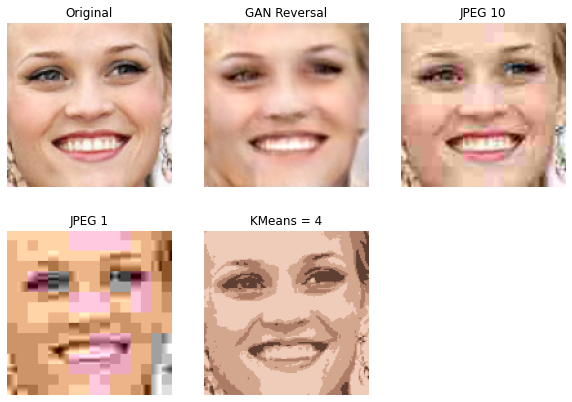

(128, 128, 3)


2022-12-02 11:54:57.098667: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:54:57.099811: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:54:57.101056: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:54:57.101742: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:54:57.102900: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 50944.251443, z_loss = 0.850612
1000) eta=0.100000, loss = 15952.670838, z_loss = 1.000000


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


(128, 128, 3)


2022-12-02 11:55:44.482623: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:55:44.484105: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:55:44.485556: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:55:44.486431: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:55:44.487809: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 51034.793821, z_loss = 0.850612
1000) eta=0.100000, loss = 18785.591877, z_loss = 1.036935


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


(128, 128, 3)


2022-12-02 11:56:31.149268: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:56:31.150142: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:56:31.151321: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:56:31.152042: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:56:31.153124: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 50471.939676, z_loss = 0.850612
1000) eta=0.100000, loss = 21246.688807, z_loss = 1.051239


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


(128, 128, 3)


2022-12-02 11:57:17.671446: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:57:17.672596: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:57:17.673861: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:57:17.674662: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:57:17.675745: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 51680.524027, z_loss = 0.850612
1000) eta=0.100000, loss = 28047.180627, z_loss = 0.984166


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


(128, 128, 3)


2022-12-02 11:58:04.798582: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:58:04.799430: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:58:04.800597: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:58:04.801299: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:58:04.802581: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 55474.625985, z_loss = 0.850612
1000) eta=0.100000, loss = 21195.888801, z_loss = 1.030384


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


<Figure size 216x216 with 0 Axes>

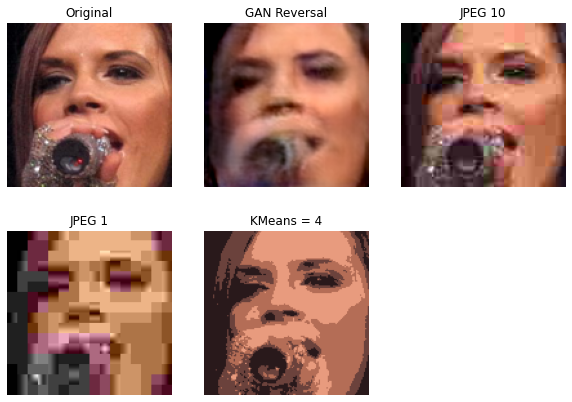

(128, 128, 3)


2022-12-02 11:58:51.868790: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:58:51.869792: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:58:51.870905: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:58:51.871572: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:58:51.872579: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 49624.885328, z_loss = 0.850612
1000) eta=0.100000, loss = 13044.505173, z_loss = 1.018055


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


(128, 128, 3)


2022-12-02 11:59:38.355911: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:59:38.356959: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:59:38.358090: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:59:38.358827: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 11:59:38.360020: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 48817.166394, z_loss = 0.850612
1000) eta=0.100000, loss = 17840.406351, z_loss = 1.034351


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


(128, 128, 3)


2022-12-02 12:00:25.222947: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:00:25.223905: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:00:25.224916: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:00:25.225559: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:00:25.226538: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 48096.110170, z_loss = 0.850612
1000) eta=0.100000, loss = 17515.944421, z_loss = 1.026545


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


(128, 128, 3)


2022-12-02 12:01:11.702464: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:01:11.703487: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:01:11.704561: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:01:11.705245: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:01:11.706364: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 56655.044957, z_loss = 0.850612
1000) eta=0.100000, loss = 25332.095294, z_loss = 1.012588


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


(128, 128, 3)


2022-12-02 12:01:58.038912: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:01:58.039740: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:01:58.040861: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:01:58.041496: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:01:58.042549: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 54969.420370, z_loss = 0.850612
1000) eta=0.100000, loss = 26439.951687, z_loss = 1.033095


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


<Figure size 216x216 with 0 Axes>

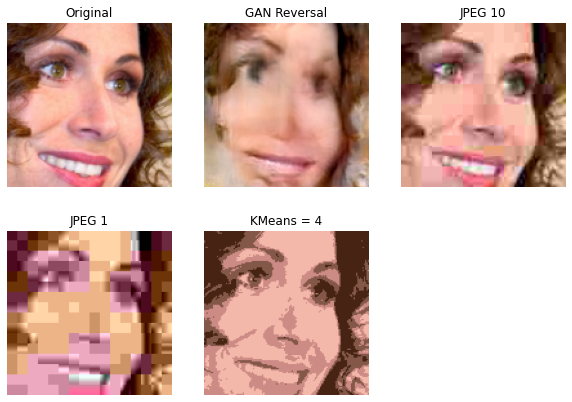

(128, 128, 3)


2022-12-02 12:02:44.846787: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:02:44.847648: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:02:44.848778: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:02:44.849413: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:02:44.850439: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 50045.404887, z_loss = 0.850612
1000) eta=0.100000, loss = 14834.702504, z_loss = 1.046998


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


(128, 128, 3)


2022-12-02 12:03:31.747838: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:03:31.748745: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:03:31.749912: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:03:31.750551: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:03:31.751606: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 57780.179630, z_loss = 0.850612
1000) eta=0.100000, loss = 16209.213388, z_loss = 1.043132


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


(128, 128, 3)


2022-12-02 12:04:18.287869: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:04:18.288755: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:04:18.289873: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:04:18.290517: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:04:18.291564: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 54297.683600, z_loss = 0.850612
1000) eta=0.100000, loss = 23234.183331, z_loss = 1.067740


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


(128, 128, 3)


2022-12-02 12:05:04.827798: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:05:04.828851: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:05:04.829884: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:05:04.830556: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:05:04.831770: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 52492.157511, z_loss = 0.850612
1000) eta=0.100000, loss = 23966.576247, z_loss = 1.009456


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


(128, 128, 3)


2022-12-02 12:05:51.584232: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:05:51.585301: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:05:51.586334: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:05:51.587119: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:05:51.588234: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 59326.663283, z_loss = 0.850612
1000) eta=0.100000, loss = 21628.698497, z_loss = 1.026209


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


<Figure size 216x216 with 0 Axes>

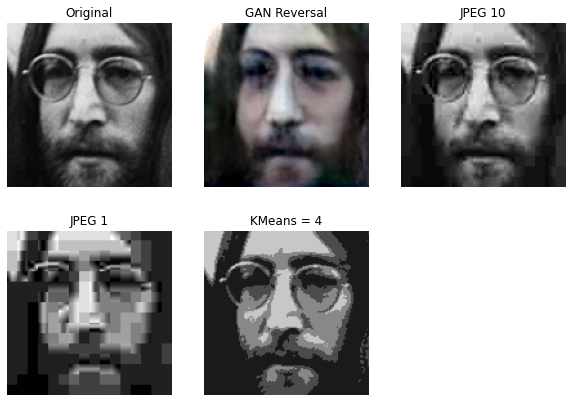

(128, 128, 3)


2022-12-02 12:06:38.283260: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:06:38.284279: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:06:38.285361: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:06:38.286005: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:06:38.287068: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 51457.751253, z_loss = 0.850612
1000) eta=0.100000, loss = 23630.184630, z_loss = 1.040844


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


(128, 128, 3)


2022-12-02 12:07:24.751179: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:07:24.752111: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:07:24.753136: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:07:24.753835: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:07:24.755106: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 55042.265882, z_loss = 0.850612
1000) eta=0.100000, loss = 19477.726941, z_loss = 0.988370


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


(128, 128, 3)


2022-12-02 12:08:11.453177: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:08:11.454137: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:08:11.455392: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:08:11.456168: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:08:11.457335: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 48007.722732, z_loss = 0.850612
1000) eta=0.100000, loss = 16264.280641, z_loss = 1.025696


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


(128, 128, 3)


2022-12-02 12:08:58.364971: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:08:58.366002: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:08:58.367089: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:08:58.367794: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:08:58.368915: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 50586.077875, z_loss = 0.850612
1000) eta=0.100000, loss = 15870.992397, z_loss = 1.057404


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


(128, 128, 3)


2022-12-02 12:09:45.093672: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:09:45.094569: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:09:45.095581: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:09:45.096268: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:09:45.097270: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 52519.125272, z_loss = 0.850612
1000) eta=0.100000, loss = 18462.397331, z_loss = 1.007745


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


<Figure size 216x216 with 0 Axes>

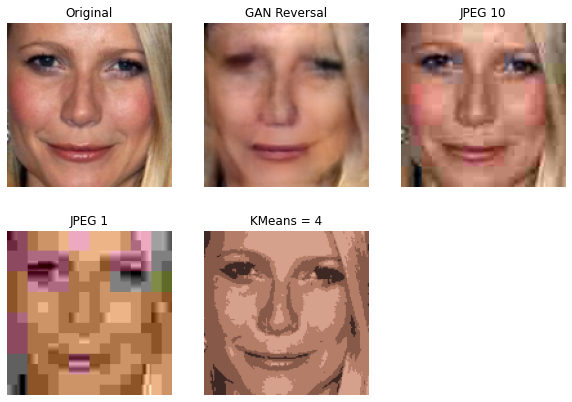

(128, 128, 3)


2022-12-02 12:10:31.858336: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:10:31.859258: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:10:31.860340: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:10:31.861000: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:10:31.862059: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 51729.355131, z_loss = 0.850612
1000) eta=0.100000, loss = 18417.566045, z_loss = 1.032632


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


(128, 128, 3)


2022-12-02 12:11:18.900044: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:11:18.900878: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:11:18.901982: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:11:18.902612: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:11:18.903644: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 50687.910435, z_loss = 0.850612
1000) eta=0.100000, loss = 22409.403160, z_loss = 0.991225


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


(128, 128, 3)


2022-12-02 12:12:05.270512: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:12:05.271410: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:12:05.272511: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:12:05.273165: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:12:05.274203: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 56117.809796, z_loss = 0.850612
1000) eta=0.100000, loss = 26109.300117, z_loss = 1.003401


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


(128, 128, 3)


2022-12-02 12:12:51.582588: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:12:51.583855: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:12:51.585081: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:12:51.585766: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:12:51.586732: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 50971.060297, z_loss = 0.850612
1000) eta=0.100000, loss = 22090.398346, z_loss = 1.021542


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


(128, 128, 3)


2022-12-02 12:13:38.988744: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:13:38.989958: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:13:38.991074: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:13:38.991773: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:13:38.992930: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 52249.300383, z_loss = 0.850612
1000) eta=0.100000, loss = 18815.989713, z_loss = 1.017008


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


<Figure size 216x216 with 0 Axes>

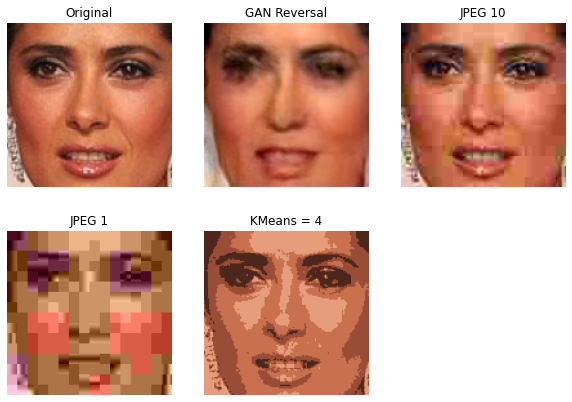

(128, 128, 3)


2022-12-02 12:14:25.966050: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:14:25.966932: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:14:25.968097: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:14:25.968741: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:14:25.969792: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 49449.032892, z_loss = 0.850612
1000) eta=0.100000, loss = 19868.678083, z_loss = 1.023069


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


(128, 128, 3)


2022-12-02 12:15:12.901396: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:15:12.902427: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:15:12.903578: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:15:12.904434: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:15:12.905663: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 52377.554217, z_loss = 0.850612
1000) eta=0.100000, loss = 23415.128557, z_loss = 1.034255


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


(128, 128, 3)


2022-12-02 12:15:59.470097: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:15:59.471017: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:15:59.472167: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:15:59.472803: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:15:59.473906: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 52833.851212, z_loss = 0.850612
1000) eta=0.100000, loss = 25776.365706, z_loss = 1.019532


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


(128, 128, 3)


2022-12-02 12:16:46.953796: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:16:46.954658: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:16:46.955765: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:16:46.956422: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:16:46.957631: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 55282.123147, z_loss = 0.850612
1000) eta=0.100000, loss = 22553.617506, z_loss = 1.054138


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


(128, 128, 3)


2022-12-02 12:17:33.772369: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:17:33.773488: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:17:33.774518: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:17:33.775184: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:17:33.776267: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 51666.699077, z_loss = 0.850612
1000) eta=0.100000, loss = 22729.814887, z_loss = 0.989729


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


<Figure size 216x216 with 0 Axes>

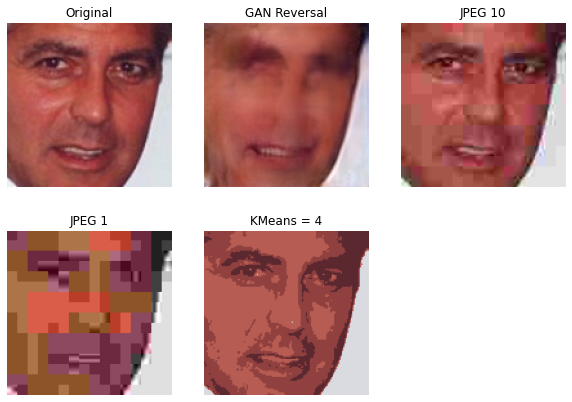

(128, 128, 3)


2022-12-02 12:18:20.929210: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:18:20.930241: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:18:20.931448: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:18:20.932144: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:18:20.933208: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 53010.203625, z_loss = 0.850612
1000) eta=0.100000, loss = 22242.771234, z_loss = 1.029023


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


(128, 128, 3)


2022-12-02 12:19:07.749024: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:19:07.749878: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:19:07.751033: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:19:07.751674: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:19:07.752754: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 52879.256116, z_loss = 0.850612
1000) eta=0.100000, loss = 14161.171241, z_loss = 0.995493


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


(128, 128, 3)


2022-12-02 12:19:54.202574: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:19:54.203521: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:19:54.204660: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:19:54.205308: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:19:54.206416: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 59858.146767, z_loss = 0.850612
1000) eta=0.100000, loss = 26031.187405, z_loss = 1.064444


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


(128, 128, 3)


2022-12-02 12:20:41.341053: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:20:41.342010: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:20:41.343108: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:20:41.343848: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:20:41.344902: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 52621.756245, z_loss = 0.850612
1000) eta=0.100000, loss = 20885.666531, z_loss = 1.057915


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


(128, 128, 3)


2022-12-02 12:21:27.725110: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:21:27.726048: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:21:27.727165: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:21:27.727797: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:21:27.728867: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 51016.100876, z_loss = 0.850612
1000) eta=0.100000, loss = 20155.703737, z_loss = 1.017346


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


<Figure size 216x216 with 0 Axes>

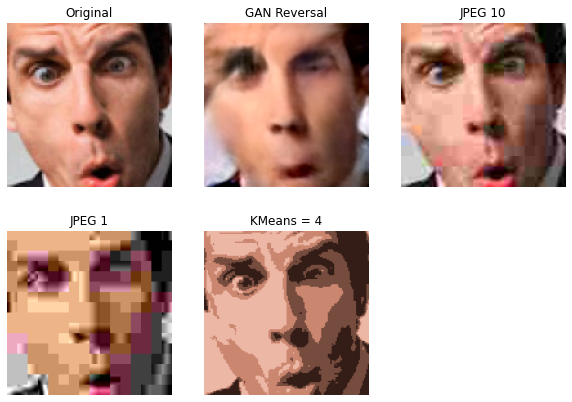

(128, 128, 3)


2022-12-02 12:22:14.711434: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:22:14.712399: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:22:14.713389: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:22:14.714024: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:22:14.715052: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 54653.810750, z_loss = 0.850612
1000) eta=0.100000, loss = 27596.596549, z_loss = 1.023640


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


(128, 128, 3)


2022-12-02 12:23:01.158722: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:23:01.159597: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:23:01.160707: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:23:01.161369: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:23:01.162432: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 52324.998477, z_loss = 0.850612
1000) eta=0.100000, loss = 18335.344993, z_loss = 0.975030


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


(128, 128, 3)


2022-12-02 12:23:47.699564: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:23:47.700589: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:23:47.701673: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:23:47.702372: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:23:47.703386: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 49151.647246, z_loss = 0.850612
1000) eta=0.100000, loss = 20108.430701, z_loss = 0.989409


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


(128, 128, 3)


2022-12-02 12:24:34.414360: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:24:34.415424: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:24:34.416598: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:24:34.417426: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:24:34.418503: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 52332.509762, z_loss = 0.850612
1000) eta=0.100000, loss = 17523.351060, z_loss = 1.028440


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


(128, 128, 3)


2022-12-02 12:25:21.103688: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:25:21.104571: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:25:21.105702: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:25:21.106346: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:25:21.107295: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 52851.513197, z_loss = 0.850612
1000) eta=0.100000, loss = 24108.368222, z_loss = 1.038852


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


<Figure size 216x216 with 0 Axes>

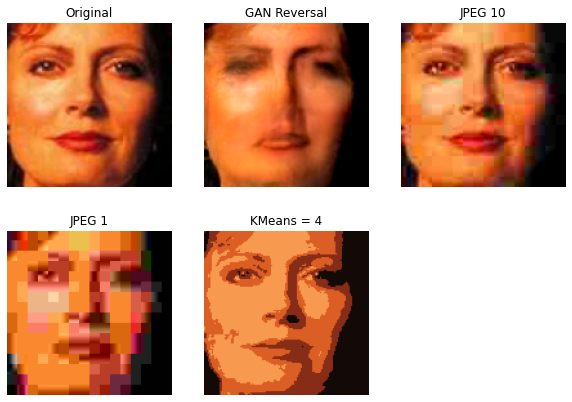

(128, 128, 3)


2022-12-02 12:26:08.067005: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:26:08.067826: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:26:08.068987: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:26:08.069610: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:26:08.070656: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 49493.395208, z_loss = 0.850612
1000) eta=0.100000, loss = 19101.984407, z_loss = 1.002608


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


(128, 128, 3)


2022-12-02 12:26:54.379872: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:26:54.380871: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:26:54.381850: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:26:54.382477: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:26:54.383546: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 48895.201591, z_loss = 0.850612
1000) eta=0.100000, loss = 17770.270018, z_loss = 1.003213


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


(128, 128, 3)


2022-12-02 12:27:41.193851: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:27:41.195012: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:27:41.196217: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:27:41.197023: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:27:41.198259: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 53914.274749, z_loss = 0.850612
1000) eta=0.100000, loss = 19801.130779, z_loss = 1.032083


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


(128, 128, 3)


2022-12-02 12:28:27.639027: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:28:27.639992: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:28:27.641115: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:28:27.641754: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:28:27.642774: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 52108.516113, z_loss = 0.850612
1000) eta=0.100000, loss = 15493.784814, z_loss = 1.057712


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


(128, 128, 3)


2022-12-02 12:29:14.497039: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:29:14.498321: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:29:14.499509: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:29:14.500230: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:29:14.501294: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 55875.592174, z_loss = 0.850612
1000) eta=0.100000, loss = 21378.392096, z_loss = 1.034111


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


<Figure size 216x216 with 0 Axes>

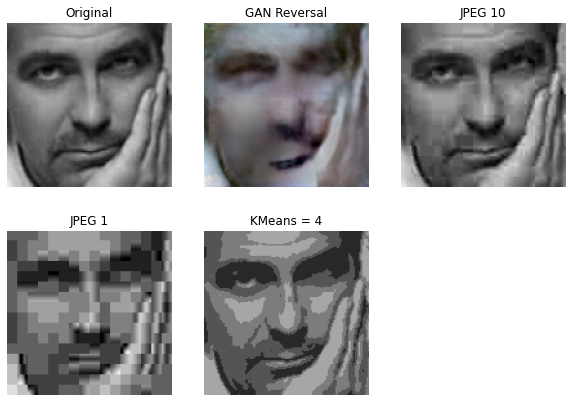

(128, 128, 3)


2022-12-02 12:30:01.595458: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:30:01.596731: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:30:01.598066: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:30:01.598815: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:30:01.599941: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 50516.724452, z_loss = 0.850612
1000) eta=0.100000, loss = 16328.196327, z_loss = 1.042630


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


(128, 128, 3)


2022-12-02 12:30:47.928926: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:30:47.929760: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:30:47.931053: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:30:47.931735: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:30:47.932911: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 49514.343864, z_loss = 0.850612
1000) eta=0.100000, loss = 20846.408634, z_loss = 1.005026


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


(128, 128, 3)


2022-12-02 12:31:34.464271: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:31:34.465185: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:31:34.466240: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:31:34.466878: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:31:34.467905: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 51716.065040, z_loss = 0.850612
1000) eta=0.100000, loss = 16915.712138, z_loss = 1.017752


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


(128, 128, 3)


2022-12-02 12:32:21.094375: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:32:21.095224: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:32:21.096326: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:32:21.096997: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:32:21.098063: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 50006.108232, z_loss = 0.850612
1000) eta=0.100000, loss = 12968.865216, z_loss = 1.022894


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


(128, 128, 3)


2022-12-02 12:33:08.036091: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:33:08.037016: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:33:08.038097: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:33:08.038744: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:33:08.039720: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 51629.189162, z_loss = 0.850612
1000) eta=0.100000, loss = 19122.363321, z_loss = 1.042210


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


<Figure size 216x216 with 0 Axes>

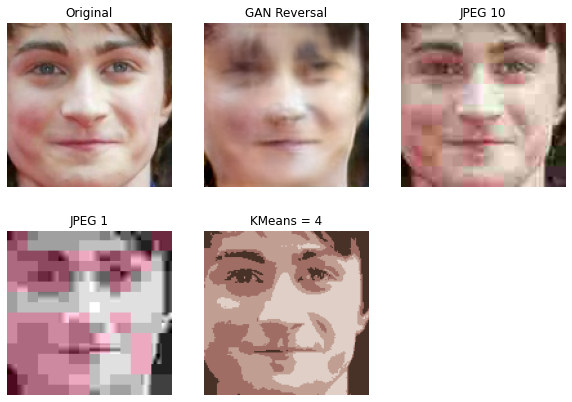

(128, 128, 3)


2022-12-02 12:33:54.860097: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:33:54.861063: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:33:54.862211: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:33:54.862872: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:33:54.863960: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 51328.768770, z_loss = 0.850612
1000) eta=0.100000, loss = 18628.796710, z_loss = 1.026214


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


(128, 128, 3)


2022-12-02 12:34:41.255234: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:34:41.256797: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:34:41.258423: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:34:41.259253: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:34:41.260472: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 54326.492362, z_loss = 0.850612
1000) eta=0.100000, loss = 24287.166260, z_loss = 1.035275


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


(128, 128, 3)


2022-12-02 12:35:28.352257: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:35:28.353385: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:35:28.354495: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:35:28.355175: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:35:28.356209: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 47161.838874, z_loss = 0.850612
1000) eta=0.100000, loss = 15904.169177, z_loss = 1.011243


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


(128, 128, 3)


2022-12-02 12:36:14.928957: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:36:14.929784: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:36:14.930986: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:36:14.931621: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:36:14.932737: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 47447.849071, z_loss = 0.850612
1000) eta=0.100000, loss = 11330.060197, z_loss = 1.025645


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


(128, 128, 3)


2022-12-02 12:37:01.545624: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:37:01.546488: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:37:01.547676: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:37:01.548319: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:37:01.549418: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 51562.808472, z_loss = 0.850612
1000) eta=0.100000, loss = 22372.928081, z_loss = 1.009305


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


<Figure size 216x216 with 0 Axes>

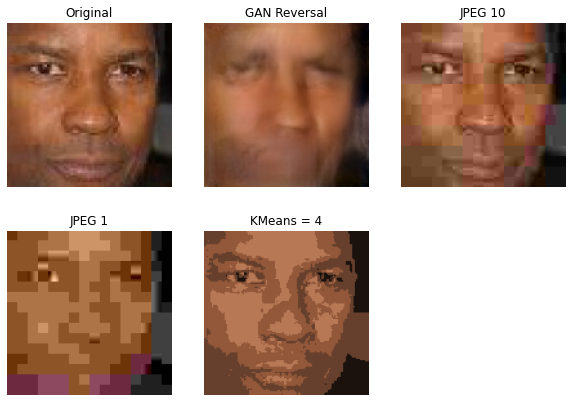

(128, 128, 3)


2022-12-02 12:37:49.158372: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:37:49.159492: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:37:49.161411: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:37:49.162744: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:37:49.164244: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 52643.251388, z_loss = 0.850612
1000) eta=0.100000, loss = 21998.162247, z_loss = 1.031099


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


(128, 128, 3)


2022-12-02 12:38:36.090163: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:38:36.091196: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:38:36.092346: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:38:36.093051: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:38:36.094180: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 51778.120346, z_loss = 0.850612
1000) eta=0.100000, loss = 14775.747831, z_loss = 1.053933


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


(128, 128, 3)


2022-12-02 12:39:22.851424: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:39:22.852350: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:39:22.853503: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:39:22.854165: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:39:22.855210: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 56577.874061, z_loss = 0.850612
1000) eta=0.100000, loss = 23625.215864, z_loss = 1.018968


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


(128, 128, 3)


2022-12-02 12:40:09.181427: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:40:09.182345: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:40:09.183482: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:40:09.184235: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:40:09.185406: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 51929.295614, z_loss = 0.850612
1000) eta=0.100000, loss = 25457.139972, z_loss = 1.019277


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


(128, 128, 3)


2022-12-02 12:40:56.730577: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:40:56.731722: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:40:56.733090: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:40:56.733802: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:40:56.735040: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 53214.198187, z_loss = 0.850612
1000) eta=0.100000, loss = 18946.313220, z_loss = 1.023291


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


<Figure size 216x216 with 0 Axes>

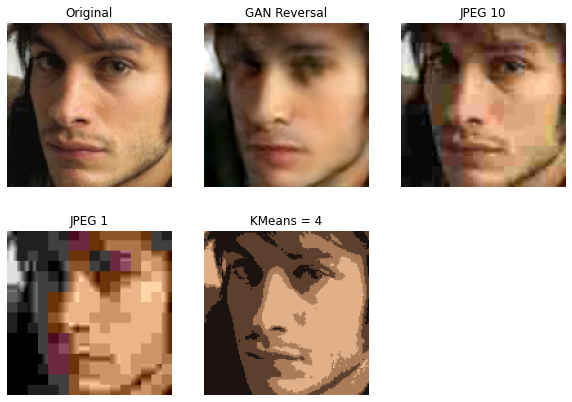

(128, 128, 3)


2022-12-02 12:41:43.385736: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:41:43.386703: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:41:43.387947: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:41:43.388638: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:41:43.389780: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 53165.599631, z_loss = 0.850612
1000) eta=0.100000, loss = 14150.799622, z_loss = 1.031007


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


(128, 128, 3)


2022-12-02 12:42:30.328582: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:42:30.330016: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:42:30.331284: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:42:30.332102: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:42:30.333224: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 48157.212031, z_loss = 0.850612
1000) eta=0.100000, loss = 12989.965028, z_loss = 1.055448


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


(128, 128, 3)


2022-12-02 12:43:16.991864: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:43:16.992698: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:43:16.993763: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:43:16.994398: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:43:16.995418: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 53127.822286, z_loss = 0.850612
1000) eta=0.100000, loss = 23866.968392, z_loss = 1.000191


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


(128, 128, 3)


2022-12-02 12:44:03.568798: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:44:03.570550: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:44:03.571986: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:44:03.572964: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:44:03.574338: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

000) eta=0.100000, loss = 51941.442347, z_loss = 0.850612
1000) eta=0.100000, loss = 22374.129577, z_loss = 1.046513


/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


<Figure size 216x216 with 0 Axes>

In [14]:
generator = hub.Module("https://tfhub.dev/google/progan-128/1")

for j in range(100):
  tf.reset_default_graph()

  generator = hub.Module("https://tfhub.dev/google/progan-128/1")

  nimg = test_set[j]

  print(nimg.shape)

  # plt.imshow(nimg)
  # plt.show()

  nimg = (nimg).astype(np.float32)

  # print(nimg)

  truth = tf.Variable(nimg, tf.float32)
  truth = tf.expand_dims(truth, 0)
  truth = tf.cast(truth, tf.float32) 

  # plt.imshow((nimg * 255).astype(np.uint8))
  # plt.title('Original')
  # plt.show()

  np.random.seed(42)
  zp1 = np.random.uniform(low=-1.0, high=1.0, size=(1, 512))
  zp = tf.Variable(zp1, dtype=tf.float32)
  reconstructed = generator(zp)
  # loss_rec = tf.reduce_mean(tf.image.ssim(truth, reconstructed, 2.0))
  # loss_rec = tf.reduce_mean(tf.image.ssim(truth, reconstructed, max_val=1))
  loss_rec = 1 - tf.reduce_mean(tf.image.ssim(truth, reconstructed, max_val=1, filter_size=20))
  loss_rec1 = tf.losses.mean_squared_error(labels=truth, predictions=reconstructed)
  loss_rec2 = -tf.reduce_mean(tf.image.psnr(truth, reconstructed, max_val=1))
  inter_loss = tf.add(loss_rec, 10 * loss_rec1)
  final_loss = tf.add(inter_loss, 0.1 * loss_rec2)
  global_step = tf.Variable(0, trainable=False)
  starter_learning_rate = 0.1
  learning_rate = tf.train.exponential_decay(starter_learning_rate,
                                            global_step,
                                            10000, 0.005)
  optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

  train = optimizer.minimize(final_loss, var_list=zp)

  sess = tf.Session()
  sess.run(tf.global_variables_initializer())
  for i in range(1500):
    _, loss_value, zp_val, eta = sess.run((train, loss_rec, zp, learning_rate))
    zp_val = np.clip(zp_val, -1, 1)
    z_loss = np.sqrt(np.sum(np.square(zp_val - z_np))/len(zp_val[0]))
    if i%1000 == 0:
      print("%03d) eta=%03f, loss = %f, z_loss = %f" % (i, eta, loss_value*255*255, z_loss))
  
  img_rec = sess.run(generator(zp))
  img_rec = (img_rec * 255).astype(np.uint8)
  img_rec = img_rec.reshape((128, 128, 3))
  plt.axis('off')
  fig = plt.gcf()
  fig.set_size_inches( 3, 3 )

  plt.imshow((nimg * 255).astype(np.uint8))
  plt.savefig('original.png', bbox_inches='tight', pad_inches=0, dpi=170)
  # plt.title('Original')
  # plt.show()

  plt.clf()

  plt.axis('off')
  fig = plt.gcf()
  fig.set_size_inches( 3, 3 )
  plt.imshow(img_rec)
  # plt.title('Reconstructed')
  # plt.show()
  plt.savefig('reconstructed.png', bbox_inches='tight', pad_inches=0, dpi=170)

  plt.clf()

  PIL_image = Image.fromarray((nimg * 255).astype(np.uint8))

  # display(PIL_image)

  buffer = BytesIO()
  PIL_image.save(buffer, "JPEG", quality=10)

  # ... do something else ...

  # write the buffer to a file to make sure it worked
  with open("photo-quality10.jpeg", "wb") as handle:
      buffer.seek(0)
      handle.write(buffer.getbuffer())

  # im = Image.open("photo-quality10.jpeg")
 
  image_jpeg10 = plt.imread("photo-quality10.jpeg")
  plt.axis('off')
  fig = plt.gcf()
  fig.set_size_inches( 3, 3 )
  plt.imshow(image_jpeg10)
  # plt.title('JPEG-10')
  # plt.show()

  plt.clf()

  buffer = BytesIO()
  PIL_image.save(buffer, "JPEG", quality=1)

  # ... do something else ...

  # write the buffer to a file to make sure it worked
  with open("photo-quality1.jpeg", "wb") as handle:
      buffer.seek(0)
      handle.write(buffer.getbuffer())

  image_jpeg1 = plt.imread("photo-quality1.jpeg")
  plt.axis('off')
  fig = plt.gcf()
  fig.set_size_inches( 3, 3 )
  plt.imshow(image_jpeg1)
  # plt.title('JPEG-1')
  # plt.show()

  plt.clf()

  kmeansimg = (nimg * 255).astype(np.uint8).reshape(-1, 3)

  kmeans = KMeans(n_clusters=4)
  kmeans.fit(kmeansimg)

  compressed_image = kmeans.cluster_centers_[kmeans.labels_]
  compressed_image = np.clip(compressed_image.astype('uint8'), 0, 255)

  compressed_image = compressed_image.reshape(128, 128, 3)
  plt.axis('off')
  fig = plt.gcf()
  fig.set_size_inches( 3, 3 )
  plt.imshow(compressed_image)
  # plt.title('Kmeans = 4')
  plt.savefig('kmeans4.png', bbox_inches='tight', pad_inches=0, dpi=170)

  plt.clf()

  compute_results_table("original.png", "reconstructed.png", "photo-quality1.jpeg", "photo-quality10.jpeg", 'kmeans4.png', error_orig, error_gan, error_jpeg1,\
                        error_jpeg10, error_km)

  if j % 5 != 0:
    continue

  fig=plt.figure(figsize=(10,7))
  columns = 3
  rows = 2
  a=np.random.rand(2,3)
  
  fig.add_subplot(rows, columns, 1)
  plt.axis('off')
  plt.imshow((nimg * 255).astype(np.uint8))
  plt.title('Original')

  fig.add_subplot(rows, columns, 2)
  plt.axis('off')
  plt.imshow(img_rec)
  plt.title('GAN Reversal')

  fig.add_subplot(rows, columns, 3)
  plt.axis('off')
  plt.imshow(image_jpeg10)
  plt.title('JPEG 10')

  fig.add_subplot(rows, columns, 4)
  plt.axis('off')
  plt.imshow(image_jpeg1)
  plt.title('JPEG 1')

  fig.add_subplot(rows, columns, 5)
  plt.axis('off')
  plt.imshow(compressed_image)
  plt.title('KMeans = 4')

  plt.show()

  # plt.show()
  plt.clf()

In [15]:
error_gan = np.matrix(error_gan)
error_jpeg1 = np.matrix(error_jpeg1)
error_jpeg10 = np.matrix(error_jpeg10)
error_km = np.matrix(error_km)
error_orig = np.matrix(error_orig)

print(error_gan.shape)

mean_error_gan = np.mean(error_gan, axis=0)
mean_error_jpeg1 = np.mean(error_jpeg1, axis=0)
mean_error_jpeg10 = np.mean(error_jpeg10, axis=0)
mean_error_km = np.mean(error_km, axis=0)
mean_error_orig = np.mean(error_orig, axis=0)

print(mean_error_orig.shape)

print("Scheme\t\t\tMSE\t\t\tSSIM\t\t\tPSNR\t\tBPP\t\tCR\n")
print("Uncompressed\t\t", mean_error_orig[0, 0], "\t\t\t", mean_error_orig[0, 1], "\t\t\t", mean_error_orig[0, 2], "\t\t\t", mean_error_orig[0, 3], "\t\t\t", mean_error_orig[0, 3])
print("K-Means=4\t\t", mean_error_km[0, 0], "\t", mean_error_km[0, 1], "\t", mean_error_km[0, 2], "\t", mean_error_km[0, 3], "\t", mean_error_km[0, 4])
print("JPEG (10%)\t\t", mean_error_jpeg10[0, 0], "\t", mean_error_jpeg10[0, 1], "\t", mean_error_jpeg10[0, 2], "\t", mean_error_jpeg10[0, 3], "\t", mean_error_jpeg10[0, 4])
print("JPEG (1%)\t\t", mean_error_jpeg1[0, 0], "\t", mean_error_jpeg1[0, 1], "\t", mean_error_jpeg1[0, 2], "\t", mean_error_jpeg1[0, 3], "\t", mean_error_jpeg1[0, 4])
print("GAN Reversal\t\t", mean_error_gan[0, 0], "\t", mean_error_gan[0, 1], "\t", mean_error_gan[0, 2], "\t", mean_error_gan[0, 3], "\t", mean_error_gan[0, 4])

(100, 5)
(1, 5)
Scheme			MSE			SSIM			PSNR		BPP		CR

Uncompressed		 0.0 			 1.0 			 inf 			 32.874671520996095 			 32.874671520996095
K-Means=4		 171.6171435546875 	 0.7405447012506083 	 26.028724190178835 	 4.157532678222658 	 3.3430782205255376
JPEG (10%)		 63.35467712402344 	 0.855867334044111 	 30.297938400096644 	 1.0775719604492189 	 12.705698886024702
JPEG (1%)		 280.30908752441405 	 0.6025690022355321 	 23.739798338514266 	 0.8062863769531252 	 16.9150109613457
GAN Reversal		 208.4164910888672 	 0.7218049489930624 	 25.336269704676223 	 28.492099090576172 	 0.4808044248177509


In [16]:
tf.reset_default_graph()

# img = (img / 255).astype(np.uint8)

truth = tf.Variable(img, tf.float32)
truth = tf.expand_dims(truth, 0)
truth = tf.cast(truth, tf.float32) 

np.random.seed(100)
zp1 = np.random.uniform(low=-1.0, high=1.0, size=(1, 512))
zp = tf.Variable(zp1, dtype=tf.float32)

In [17]:
generator = hub.Module("https://tfhub.dev/google/progan-128/1")

reconstructed = generator(zp)
# loss_rec = tf.reduce_mean(tf.image.ssim(truth, reconstructed, 2.0))
loss_rec = tf.losses.mean_squared_error(labels=truth, predictions=reconstructed)
global_step = tf.Variable(0, trainable=False)
starter_learning_rate = 0.99
learning_rate = tf.train.exponential_decay(starter_learning_rate,
                                           global_step,
                                           10000, 0.005)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

train = optimizer.minimize(loss_rec, var_list=zp)

sess = tf.Session()
sess.run(tf.global_variables_initializer())
for i in range(1000):
  _, loss_value, zp_val, eta = sess.run((train, loss_rec, zp, learning_rate))
  zp_val = np.clip(zp_val, -1, 1)
  z_loss = np.sqrt(np.sum(np.square(zp_val - z_np))/len(zp_val[0]))
  if i%100 == 0:
    print("%03d) eta=%03f, loss = %f, z_loss = %f" % (i, eta, loss_value, z_loss))

2022-12-02 12:44:50.054267: W tensorflow/core/common_runtime/graph_constructor.cc:1511] Importing a graph with a lower producer version 26 into an existing graph with producer version 808. Shape inference will have run different parts of the graph with different producer versions.
2022-12-02 12:44:51.158310: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:44:51.159243: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:44:51.160265: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 12:44:51.160907: I tensorflow/stream_executor/c

000) eta=0.990000, loss = 0.853375, z_loss = 0.803015
100) eta=0.990000, loss = 0.444258, z_loss = 1.055641
200) eta=0.990000, loss = 0.120543, z_loss = 0.980681
300) eta=0.990000, loss = 0.093909, z_loss = 0.949061
400) eta=0.990000, loss = 0.077261, z_loss = 0.949044
500) eta=0.990000, loss = 0.083900, z_loss = 0.937086
600) eta=0.990000, loss = 0.057692, z_loss = 0.927596
700) eta=0.990000, loss = 0.056138, z_loss = 0.922130
800) eta=0.990000, loss = 0.066383, z_loss = 0.916354
900) eta=0.990000, loss = 0.053800, z_loss = 0.908550


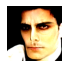

In [18]:
img_rec = sess.run(generator(zp))
img_rec = (img_rec * 255).astype(np.uint8)
img_rec = img_rec.reshape((128, 128, 3))
plt.imshow(img_rec)
plt.axis('off')
fig = plt.gcf()
fig.set_size_inches( 1, 1 )
plt.imshow(img_rec)
plt.savefig('reconstructed-combined-loss.png', bbox_inches='tight', pad_inches=0, dpi=170)